In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN model class
class AllConvNet(nn.Module):
    def __init__(self):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(512, 10, kernel_size=3, padding='same')
        self.relu = nn.LeakyReLU()
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.avg_pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.avg_pool(x)
        x = self.relu(self.conv5(x))
        x = self.relu(self.global_avg_pool(x)).squeeze()
        return x

# Create an instance of the model and move it to the GPU(s)
device = torch.device("cuda:0")  # Use GPU 0
net = AllConvNet().to(device)
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Training loop
num_epochs = 10
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_history.append(running_loss / (i + 1))
    print(f'Epoch {epoch+1}, Loss: {running_loss / (i+1)}')

print('Finished Training')

# Test the model
correct = 0
total = 0
net.eval()  # Set the model to evaluation mode
all_labels = []
all_preds = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(predicted.cpu().tolist())

print(f'Accuracy on the test dataset: {100 * correct / total:.2f}%')



# Select a GPU for image display
torch.cuda.device(0)




100%|██████████| 170498071/170498071 [00:13<00:00, 12182092.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Loss: 1.6817300045276846
Epoch 2, Loss: 1.1246322097680759
Epoch 3, Loss: 0.8783066904605807
Epoch 4, Loss: 0.7093281122424718
Epoch 5, Loss: 0.5974538480610494
Epoch 6, Loss: 0.5132948530032811
Epoch 7, Loss: 0.4379739532309115
Epoch 8, Loss: 0.36866202826618844
Epoch 9, Loss: 0.31064257516389915
Epoch 10, Loss: 0.2523872888673221
Finished Training
Accuracy on the test dataset: 82.46%


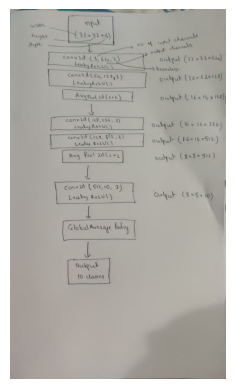

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/DLNN.jpg'
img = mpimg.imread(image_path)


plt.imshow(img)
plt.axis('off')
plt.show()

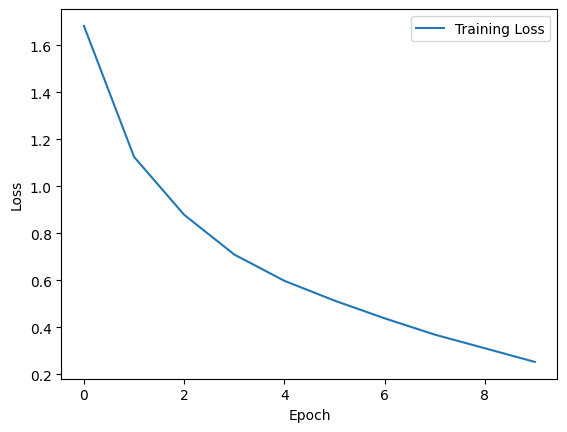

In [2]:
# Plot learning curve
plt.plot(range(num_epochs), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

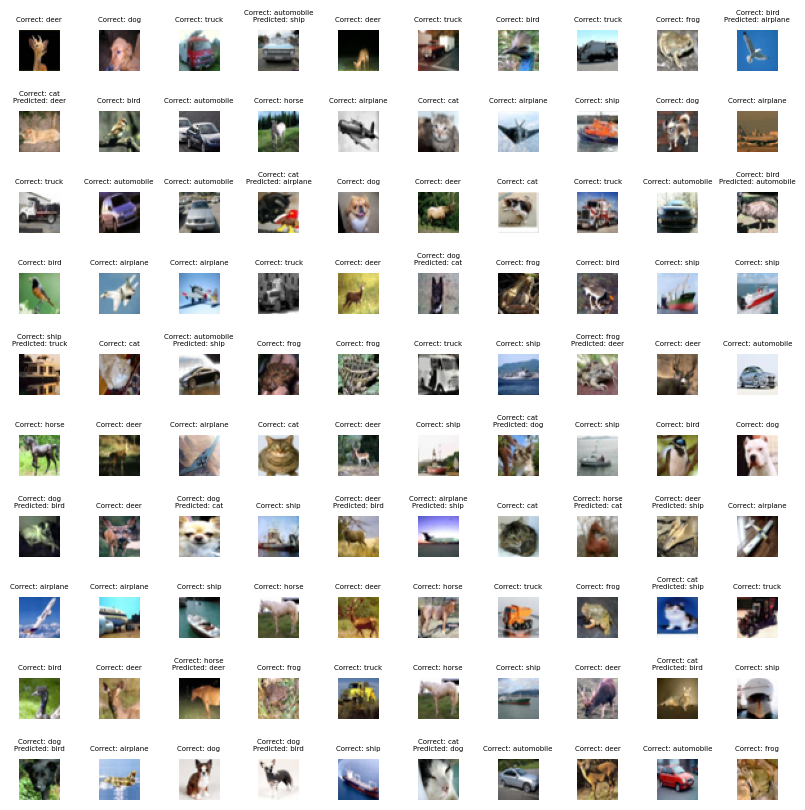

In [10]:

# Display a 10x10 image array of correctly/incorrectly classified images
num_images = 100
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Add spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=1)

for i in range(10):
    for j in range(10):
        index = np.random.randint(len(testset))
        img, label = testset[index]
        img = img.numpy().transpose((1, 2, 0))

        # Normalize image data to [0, 1]
        img = (img - img.min()) / (img.max() - img.min())

        axes[i, j].imshow(img)
        predicted = all_preds[index]
        correct_label = class_labels[label]

        if predicted == label:
            axes[i, j].set_title(f'Correct: {correct_label}', fontsize=5)
        else:
            axes[i, j].set_title(f'Correct: {correct_label}\nPredicted: {class_labels[predicted]}', fontsize=5)
        axes[i, j].axis('off')

plt.show()






In [11]:
# Print confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

[[849  12  24   6   9   1   1   4  79  15]
 [  6 919   3   2   0   2   1   1  36  30]
 [ 55   4 779  28  53  24  25  12  16   4]
 [ 19   6  79 680  53  87  12  24  28  12]
 [  8   0  63  25 837  20  12  23  10   2]
 [  6   4  66 121  36 731   0  22   7   7]
 [ 10   8  43  56  44  16 810   6   7   0]
 [ 14   2  36  23  49  29   3 829   3  12]
 [ 22   7   2   6   2   1   3   2 943  12]
 [ 20  69   5   5   0   2   0   0  30 869]]
